In [ ]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/corino

/gdrive/MyDrive/corino


### Import libraries

In [ ]:

import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

################################################################################### # Random seed for reproducibility

seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

###################################################################################  Suppress warnings

import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
###################################################################################  Suppress warnings



2.11.0


In [ ]:
# # # Load the dataset to be used fonr classification
# !unzip dataset4.zip

In [ ]:
# Dataset folders 
dataset_dir = 'dataset4'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')


labels = ["class1",   #0
          "class2",   #1
          "class3",   #2
         ]

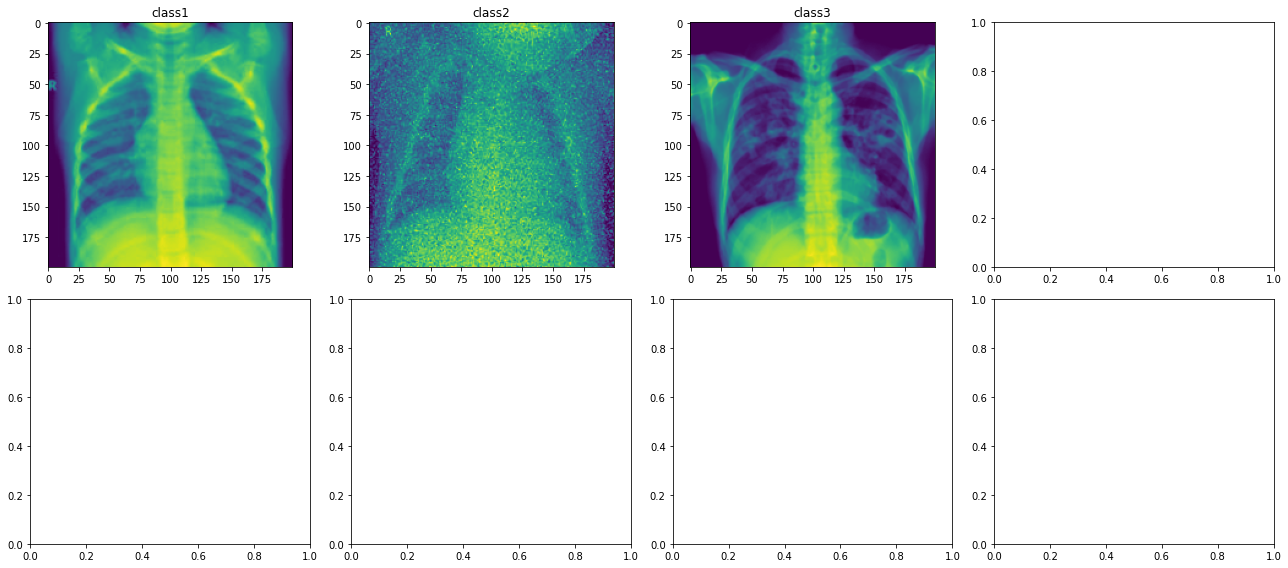

In [ ]:
num_row = 2
num_col = 4
fig, axes = plt.subplots(num_row, num_col, figsize=(9*num_row,2*num_col))
for i in range(num_row*num_col):
  if i < 3:
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [ ]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input



# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(200,200),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)
valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(200,200),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)
test_gen = train_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(200,200),
                                              color_mode='rgb',
                                              classes=None, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

###################################################################################




Found 11603 images belonging to 3 classes.
Found 1547 images belonging to 3 classes.
Found 2319 images belonging to 3 classes.


## Models metadata

In [ ]:
input_shape = (200, 200, 3)
epochs = 200

In [ ]:
class_weights = compute_class_weight(class_weight = 'balanced',classes=np.unique(train_gen.classes), y=train_gen.classes)
class_weights= dict(enumerate(class_weights.flatten(), 0))


## Transfer learning

In [ ]:
del tl_model
del tl_history

del ft_model
del ft_history

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

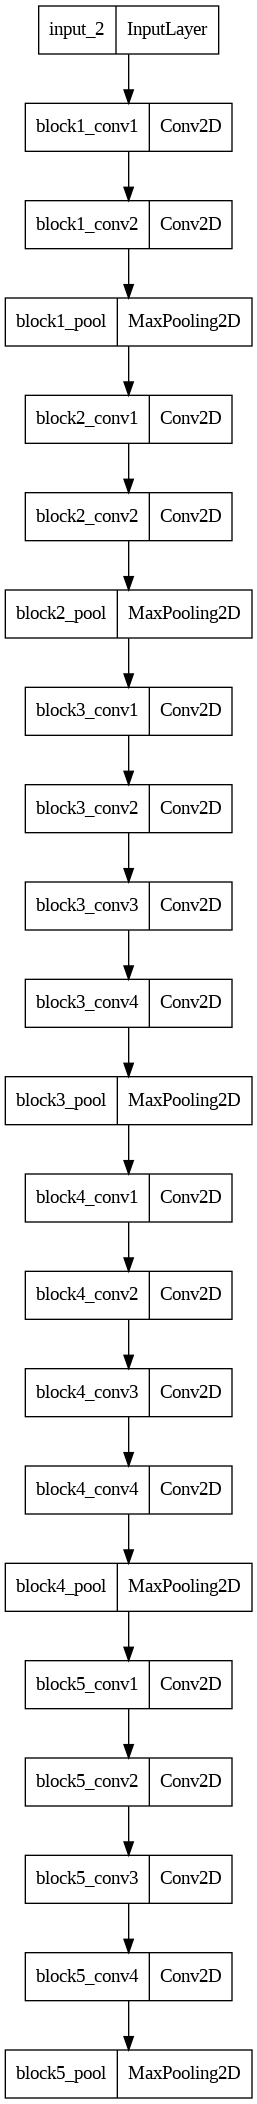

In [ ]:
# #Download and plot the VGG16 model
# supernet = tfk.applications.VGG16(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(224,224,3)
# )
# supernet.summary()
# tfk.utils.plot_model(supernet)



#Download and plot the VGG16 model
supernet = tfk.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)



In [ ]:
# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=input_shape)
x = tfkl.Resizing(224, 224, interpolation="bicubic")(inputs)
x = supernet(x)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    512, activation='relu', kernel_initializer = tfk.initializers.HeUniform(seed), use_bias = True )(x)

x = tfkl.BatchNormalization()(x)
outputs = tfkl.Dense(
    3, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed) , use_bias = True)(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
tl_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 Flattening (Flatten)        (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048  

In [ ]:
# Train the model
tl_history = tl_model.fit(
    
    x = train_gen,
    batch_size = 512 ,
    epochs = 200,
    validation_data = test_gen,
    class_weight = class_weights,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
1451/1451 [==============================] - 7277s 5s/step - loss: 0.4210 - accuracy: 0.8262 - val_loss: 0.3510 - val_accuracy: 0.8620
Epoch 2/200
1451/1451 [==============================] - 113s 78ms/step - loss: 0.2214 - accuracy: 0.9072 - val_loss: 0.2450 - val_accuracy: 0.9008
Epoch 3/200
1451/1451 [==============================] - 114s 78ms/step - loss: 0.1847 - accuracy: 0.9205 - val_loss: 0.1964 - val_accuracy: 0.9314
Epoch 4/200
1451/1451 [==============================] - 113s 78ms/step - loss: 0.1619 - accuracy: 0.9330 - val_loss: 0.2725 - val_accuracy: 0.9069
Epoch 5/200
1451/1451 [==============================] - 113s 78ms/step - loss: 0.1335 - accuracy: 0.9439 - val_loss: 0.3051 - val_accuracy: 0.9030
Epoch 6/200
1451/1451 [==============================] - 113s 78ms/step - loss: 0.1207 - accuracy: 0.9510 - val_loss: 0.2198 - val_accuracy: 0.9332
Epoch 7/200
1451/1451 [==============================] - 113s 78ms/step - loss: 0.1001 - accuracy: 0.9573 - val_l

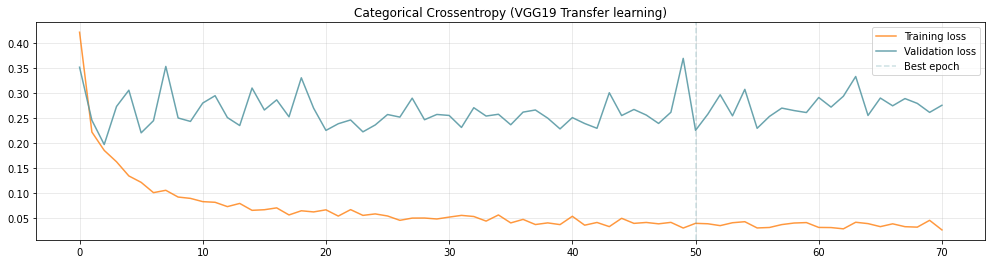

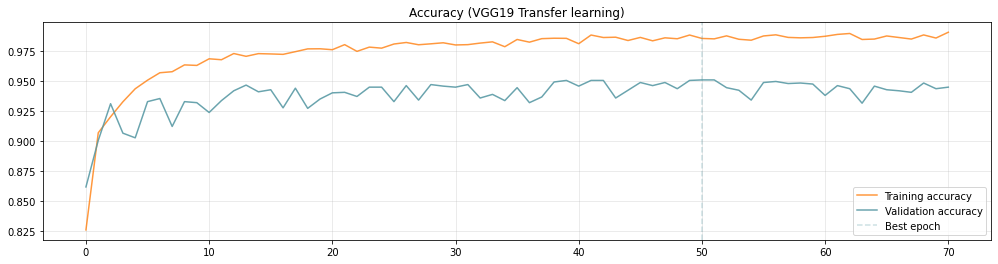

In [ ]:
best_epoch = np.argmax(tl_history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(tl_history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy (VGG19 Transfer learning)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(tl_history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy (VGG19 Transfer learning)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# plt.figure(figsize=(18,3))
# plt.plot(ft_history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
# plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
# plt.legend()
# plt.grid(alpha=.3)
# plt.show()

In [ ]:
# Save the best model
tl_model.save('NEWvgg19model224')

In [ ]:
tl_model.evaluate(test_gen, return_dict=True)

290/290 [==============================] - 19s 65ms/step - loss: 0.2247 - accuracy: 0.9513


{'loss': 0.22474989295005798, 'accuracy': 0.9512720704078674}

In [ ]:
tl_model.evaluate(valid_gen, return_dict=True)

194/194 [==============================] - 13s 63ms/step - loss: 0.1623 - accuracy: 0.9580


{'loss': 0.16229984164237976, 'accuracy': 0.9579831957817078}

## Fine tuning

In [ ]:
# Re-load the model after transfer learning
ft_model = tl_model
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 Flattening (Flatten)        (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048  

In [ ]:
# # Set all VGG layers to True
# ft_model.get_layer('vgg16').trainable = True
# for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
#    print(i, layer.name, layer.trainable)

# Set all VGG layers to True
ft_model.get_layer('vgg19').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)

0 input_2 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [ ]:
# # Freeze first N layers, e.g., until 14th
# for i, layer in enumerate(ft_model.get_layer('vgg16').layers[:0]):
#   layer.trainable=False
# for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
#    print(i, layer.name, layer.trainable)
# ft_model.summary()

# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(ft_model.get_layer('vgg19').layers[:0]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_2 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 Flattening (Fl

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = train_gen,
    batch_size = 512,
    epochs = 200,
    class_weight = class_weights,
    validation_data = test_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
1451/1451 [==============================] - 3544s 2s/step - loss: 0.4220 - accuracy: 0.8829 - val_loss: 4.5906 - val_accuracy: 0.8767
Epoch 2/200
1451/1451 [==============================] - 274s 189ms/step - loss: 0.2065 - accuracy: 0.9175 - val_loss: 0.2128 - val_accuracy: 0.9310
Epoch 3/200
1451/1451 [==============================] - 282s 195ms/step - loss: 0.1681 - accuracy: 0.9374 - val_loss: 0.1896 - val_accuracy: 0.9422
Epoch 4/200
1451/1451 [==============================] - 282s 194ms/step - loss: 0.1639 - accuracy: 0.9410 - val_loss: 57060.5898 - val_accuracy: 0.9297
Epoch 5/200
1451/1451 [==============================] - 281s 194ms/step - loss: 0.2137 - accuracy: 0.9197 - val_loss: 0.2137 - val_accuracy: 0.9267
Epoch 6/200
1451/1451 [==============================] - 281s 194ms/step - loss: 0.1577 - accuracy: 0.9403 - val_loss: 0.2277 - val_accuracy: 0.9284
Epoch 7/200
1451/1451 [==============================] - 281s 194ms/step - loss: 0.1162 - accuracy: 0.95

In [ ]:
 ft_model.evaluate(valid_gen, return_dict=True)

194/194 [==============================] - 399s 2s/step - loss: 0.1099 - accuracy: 0.9651


{'loss': 0.10993871837854385, 'accuracy': 0.965093731880188}

In [ ]:
ft_model.evaluate(test_gen, return_dict=True)

290/290 [==============================] - 17s 58ms/step - loss: 0.1315 - accuracy: 0.9629


{'loss': 0.13150541484355927, 'accuracy': 0.9629150629043579}

In [ ]:
# Save the best model
ft_model.save('NEWmodelvgg19FinetunedAllLayer224')

In [ ]:
best_epoch = np.argmax(ft_history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(ft_history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(ft_history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy (VGG19 6 layers fine tuned)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(ft_history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(ft_history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy (VGG19 6 layers fine tuned)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# plt.figure(figsize=(18,3))
# plt.plot(ft_history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
# plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
# plt.legend()
# plt.grid(alpha=.3)
# plt.show()

## Ensemble method

In [ ]:
## WE ran out of computing units to calculate but was done on previous attempts 

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average


In [ ]:
del ensemble_model

In [ ]:


modelvgg19_1 = load_model('NEWvgg19model224')
modelvgg19_2 = load_model('NEWmodelvgg19FinetunedSixLayer224')
modelvgg19_3 = load_model('NEWmodelvgg19FinetunedAllLayer224')


modelvgg16_1 = load_model('NEWvgg16model224')
modelvgg16_2 = load_model('NEWmodelvgg16FinetunedSixLayer224')
modelvgg16_3 = load_model('NEWmodelvgg16FinetunedAllLayer224')


modelvgg19_1 = Model(inputs=modelvgg19_1.inputs, outputs=modelvgg19_1.outputs, name='modelvgg19_1')
modelvgg19_2 = Model(inputs=modelvgg19_2.inputs, outputs=modelvgg19_2.outputs, name='modelvgg19_2')
modelvgg19_3 = Model(inputs=modelvgg19_2.inputs, outputs=modelvgg19_2.outputs, name='modelvgg19_3')

modelvgg16_1 = Model(inputs=modelvgg19_1.inputs, outputs=modelvgg19_1.outputs, name='modelvgg16_1')
modelvgg16_2 = Model(inputs=modelvgg19_2.inputs, outputs=modelvgg19_2.outputs, name='modelvgg16_2')
modelvgg16_3 = Model(inputs=modelvgg19_1.inputs, outputs=modelvgg19_1.outputs, name='modelvgg16_3')




#################################################################################

In [ ]:
models = [modelvgg19_1, modelvgg19_2, modelvgg16_1, modelvgg16_2, modelvgg16_3, modelvgg19_3  ]
model_input = Input(shape=(200, 200, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')
ensemble_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')


In [ ]:
ensemble_model_metrics=ensemble_model.evaluate(test_gen,return_dict=True)
ensemble_model.summary 

290/290 [==============================] - 110s 380ms/step - loss: 0.1044 - accuracy: 0.9672


<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fc7c0209ac0>>

In [ ]:
ensemble_history = ensemble_model.fit(
    x = train_gen,
    batch_size = 1024,
    epochs = 2,
    class_weight = class_weights,
    validation_data = test_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)]
).history

Epoch 1/2
 957/1451 [==================>...........] - ETA: 35:06 - loss: 0.0159 - accuracy: 0.9978

In [ ]:
# Save the best model
ensemble_model.save('ensm_wow2')

##Evaluate Model

In [ ]:
check_model = tfk.models.load_model("NEWmodelvgg19FinetunedSixLayer224")

In [ ]:
from sklearn.metrics import classification_report

def fbeta(y_true, y_pred, threshold_shift=0):
    beta_squared = 4

    y_pred = K.clip(y_pred, 0, 1)
 
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
 
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())


def confusion_matrix_plot(matrix):
    plt.figure(figsize=(12,10))
    cmap = "Blues"
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=cmap);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    # plt.savefig('/kaggle/working/img1.png')
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.yaxis.set_ticklabels(classes,fontsize='xx-large');
    ax.xaxis.set_ticklabels(classes); 
    ax.yaxis.set_ticklabels(classes[::-1]);
    plt.show()


  
def cal_score(model, key):
    matrix = confusion_matrix(predictions, labels)
    print(matrix)
    print('\n')

    f1 = f1_score(predictions, labels, average='weighted')
    print(f'F1 Score: {f1}')
    print('\n')
    
    print(classification_report(predictions, labels, target_names=classes))
    
    if key==1:
        confusion_matrix_plot(matrix)

In [ ]:
predictions = np.argmax(check_model.predict(valid_gen),axis=1)
labels = valid_gen.classes
predictions , labels

classes = []
for i in os.listdir("/gdrive/MyDrive/corino/dataset4/val"):
    classes+=[i]

# classes = ['class1', 'class2', 'class3']
classes

194/194 [==============================] - 852s 4s/step


['class3', 'class2', 'class1']

[[934   5  20]
 [  6 415   0]
 [  7   0 160]]


F1 Score: 0.9756817075692883


              precision    recall  f1-score   support

      class3       0.99      0.97      0.98       959
      class2       0.99      0.99      0.99       421
      class1       0.89      0.96      0.92       167

    accuracy                           0.98      1547
   macro avg       0.95      0.97      0.96      1547
weighted avg       0.98      0.98      0.98      1547



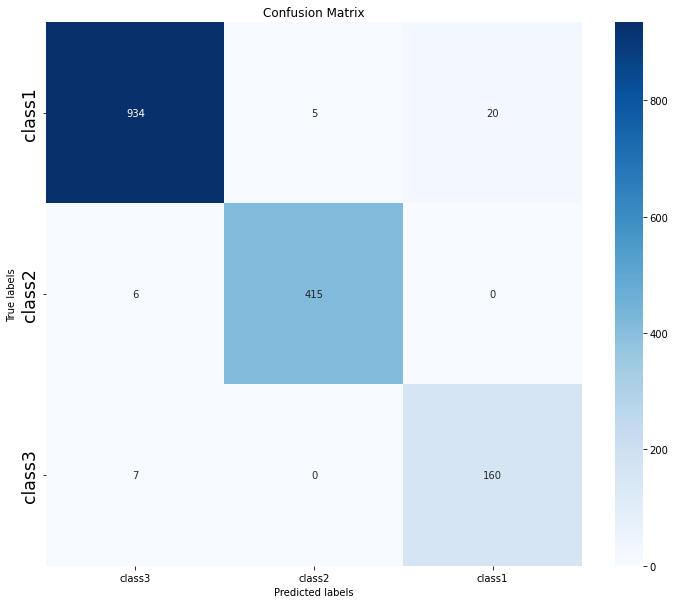

In [ ]:
cal_score(check_model, 1)